# Análisis de datos y uso de CatBoost para la predicción de clientes solicitantes de un deposito a plazo fijo                          

## Contenido

#### 1. Introducción

    * Identificación del problema
    * ¿Que es un deposito a plazo fijo?
    * Objetivos
    
#### 2. Importación de librerías y carga de datos

    
#### 3. Exploración de los datos

    * Eliminación y cambio de tipo de variables   
    
#### 4. Preprocesamiento de datos

    * Identificación de outliers
    * Imputación de outliers
    * Identificación de valores faltantes
       
#### 5. Análisis y visualización de datos

    * Análisis univariado
    * Análisis bivariado
    * Correlación de Pearson
    * V de Cramer

#### 6. Transformación de datos

    * Codificación de variables
    * Creación de conjuntos de entrenamiento y validación
    * Rebalanceo de datos

#### 7. Construcción y evaluación del modelo predictivo

    * Elección de hiperparámetros
        * Hiperparámetros para datos con outliers y sin codificación manual
        * Hiperparámetros para datos con outliers y con codificación manual
        * Hiperparámetros para datos sin outliers y sin codificación manual
        * Hiperparámetros para datos sin outliers y con codificación manual
    * Elección del mejor modelo
    
#### 8. Conclusiones

---

## 1. Introducción

### Identificación del problema

Uno de los usos más populares de la ciencia de datos es en el sector del marketing, puesto que es una herramienta muy poderosa que ayuda a las empresas a predecir de cierta forma el resultado de una campaña de marketing en base a experiencias pasadas, y que factores serán fundamentales para su éxito o fracaso. A la vez que también ayuda a conocer los perfiles de las personas que tienen más probabilidad de convertirse en futuros clientes con el fin de desarrollar estrategias personalizadas que puedan captar de forma más efectiva su interés. Conocer de antemano o a posteriori esta información es de vital importancia ya que ayuda en gran medida a que la empresa pueda conocer más acerca del público al que se tiene que enfocar, y que en el futuro se puedan desarrollar campañas de marketing que resulten más efectivas y eficientes. Entonces, se identifica que la problemática a tratar es el entender los factores que influyen a que una persona solicite o no un depósito a plazo fijo ofrecido por un determinado banco y predecir dado una serie de características, que personas solicitarán o no dicho servicio. Para ello, se requiere analizar la última campaña de marketing ejecutada por el banco y algunas características de sus clientes, con el fin de identificar patrones que nos puedan ayudar a comprender y encontrar soluciones para que el banco pueda desarrollar estrategias efectivas que les ayuden a captar el interés de las personas en solicitar este tipo de depósito, y en base a esto, construir un modelo predictivo que permita predecir que personas tomaran este servicio o no.

### ¿Qué es un depósito a plazo fijo?

Es una inversión que consiste en el depósito de una cantidad determinada de dinero a una institución financiera por un periodo de tiempo, en donde el cliente no puede retirar el dinero depositado hasta que este periodo de tiempo haya finalizado. La ventaja de este tipo de depósito es que permite ahorrar dinero ganando intereses, por lo cual, muchas personas lo ven como una forma efectiva de generar ingresos pasivos.

### Objetivos

* Realizar análisis de datos para encontrar y entender los factores que influyen a que una persona solicite o no un depósito a plazo fijo.
* Construir un modelo de aprendizaje automático con CatBoost para la predicción de solicitantes de un depósito a plazo fijo.
* Implementar correctamente cada uno de los pasos de la metodología de ciencia de datos en la elaboración de este proyecto

---

## 2. Importación de librerías y carga de datos

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import FormatStrFormatter
import association_metrics as am
from collections import Counter
from catboost import CatBoostClassifier, Pool
import optuna  
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

El conjunto de datos con el que vamos a tratar almacena características de 11162 personas a los que un banco contactó para ofrecerles el servicio de depósito a plazo fijo, e indica si estos al final decidieron solicitar dicho depósito o no.

In [13]:
data = pd.read_csv("Bank_Marketing.csv")

---

## 3. Exploración de los datos

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
data.shape

(11162, 17)

In [6]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Podemos extraer algunos insights simples de esta tabla, como que el promedio de edad de los clientes de la empresa ronda en los 41 años. También que el saldo promedio que tienen en su cuenta es de 1528, pero si observamos la desviación estándar de los datos de esta variable, observamos que tiene un valor 3225, el cual es considerablemente alto, por lo que podemos decir que el saldo de los clientes está muy distribuido en nuestro conjunto de datos, presentando una alta variación. Por último, podemos observar que la variable pdays (número de días después del último contacto en la campaña anterior del banco) tiene un valor mínimo de -1, lo cual al momento de la interpretabilidad en el análisis de datos puede resultar algo confuso, es por ello que en la sección del preprocesamiento de datos se procederá a reemplazar este valor por un 0.

### Eliminación y cambio de tipo de variables

Hay que tener en cuenta algo de suma importancia en nuestros datos, y es que la variable "duration" hace referencia al tiempo de duración en segundos del último contacto que se realizó con la persona antes que decidiera solicitar o no un depósito a plazo fijo, y como naturalmente este valor no se conoce hasta después de haber realizado la llamada que es cuando ya se sabe la decisión de la persona, se procederá a eliminar al momento de construir nuestro modelo predictivo, puesto que estaría otorgando información que de por si no se conoce de antemano.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Observamos que aparentemente todas nuestras variables de entrada parecen tener cierta relación con la decisión de una persona en solicitar o no un depósito a plazo fijo, por lo que se decide por el momento no eliminar ninguna de estas variables de forma injustificada.

También observamos que todas las variables de nuestro conjunto de datos están correctamente etiquetadas con el tipo de dato que les corresponde, por lo tanto, no se requiere realizar conversión alguna.

---

## 4. Preprocesamiento de datos

Como habíamos explicado en la sección anterior, procederemos a reemplazar los valores iguales a -1 por 0 en la variable pdays.

In [14]:
for i in range(0,data.shape[0]):
    if data["pdays"].iloc[i] == -1:
        data["pdays"].iloc[i] = 0

Entonces, si ahora observamos el valor mínimo de la variable pdays obtendremos un 0 como resultado en vez de un -1.

In [16]:
data["pdays"].min()

0

### Identificación de outliers

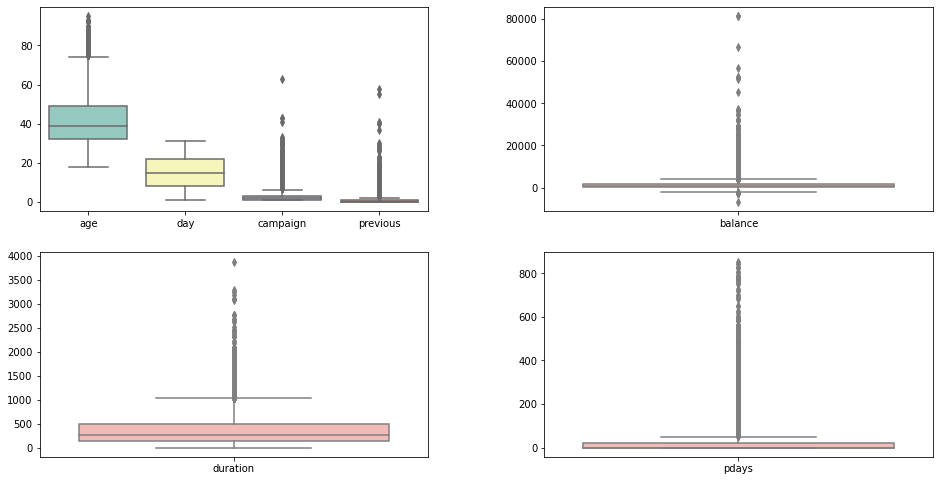

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
plt.subplots_adjust(wspace=0.3, top=0.75)
sns.boxplot(ax=ax[0][0], data= data[["age", "day", "campaign", "previous"]], palette="Set3")
sns.boxplot(ax=ax[0][1], data= data[["balance"]], palette="Pastel1")
sns.boxplot(ax=ax[1][0], data= data[["duration"]], palette="Pastel1")
sns.boxplot(ax=ax[1][1], data= data[["pdays"]], palette="Pastel1")
plt.show()

Con el diagrama de cajas observamos que tenemos presencia de outliers en todas nuestras variables numéricas excepto en la variable "day".

A continuación, visualizaremos el porcentaje de outliers con respecto al total en cada una de nuestras variables para poder considerar si debemos tomar la decisión de eliminar alguna de estas variables por su alta presencia de valores atípicos.

In [23]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

In [26]:
( (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)) ).sum() / data.shape[0] * 100

<ipython-input-26-f3c81b675d20>:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ( (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)) ).sum() / data.shape[0] * 100
<ipython-input-26-f3c81b675d20>:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ( (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)) ).sum() / data.shape[0] * 100


age           1.531984
balance       9.451711
campaign      5.384340
contact       0.000000
day           0.000000
default       0.000000
deposit       0.000000
duration      5.697904
education     0.000000
housing       0.000000
job           0.000000
loan          0.000000
marital       0.000000
month         0.000000
pdays        24.672998
poutcome      0.000000
previous     11.270382
dtype: float64

Los resultados nos arrojan que la variable "pdays" tiene un 24% de presencia de outliers respecto al total de filas, lo cual siguiendo la buena práctica de eliminar aquellas variables que superen un umbral del 15% de valores atípicos, procederemos a eliminar esta variable ya que puede inferir de forma negativa en el análisis y la predicción del futuro modelo de clasificación que se construirá. Otro dato a tomar en cuenta, es que esta variable es la misma que presentaba valores iguales a -1, los cuales reemplazamos con 0, donde quizá los valores etiquetados como -1 se debieron a una corrupción en los datos, con lo cual tenemos un motivo más para eliminar esta variable.

In [27]:
data = data.drop(["pdays"], axis=1)

#### Age

<AxesSubplot:xlabel='age', ylabel='Density'>

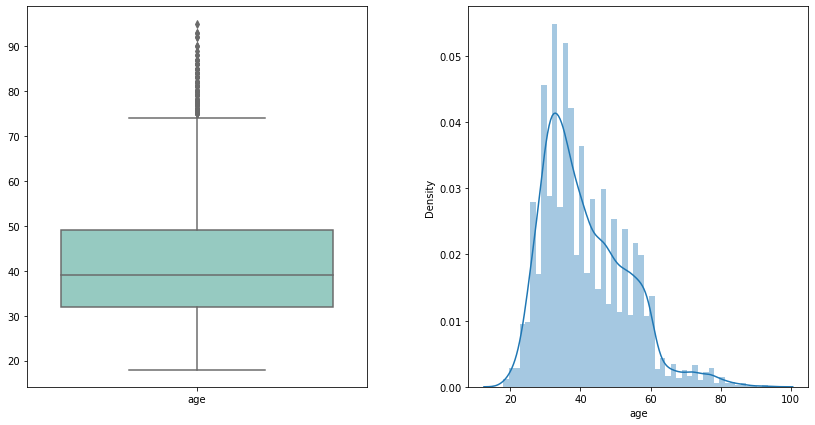

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["age"]], palette="Set3")
sns.distplot(data["age"], ax=ax[1])
plt.show()

De los siguientes gráficos podemos observar que los datos que son catalogados como atípicos según el rango intercuartílico son personas que superan los 75 años de edad sin llegar a pasar los 95 años. Este rango de edad no es ningún error o corrupción en los datos, ya que la mayoría de personas con una calidad de vida adecuada podrían alcanzar este rango, por lo tanto, tenemos dos opciones para tratarlos:
* Eliminar las filas que contengan estas edades debido a que su presencia es tan solo del 1.5% del total.
* Imputarlos haciendo uso de un algoritmo predictivo.

Todos estos métodos resultan aceptables, pero en este caso optaremos por imputarlos por un valor aproximado a lo "normal" que refleje la misma conducta que el valor atípico, más que todo para no perder información. De igual forma, al momento del entrenamiento y la elección del mejor modelo de clasificación, se comparará el rendimiento de un modelo libre de outliers con uno con outliers con el fin de observar si nuestra decisión fue acertada.

#### Campaign

<AxesSubplot:xlabel='campaign', ylabel='Density'>

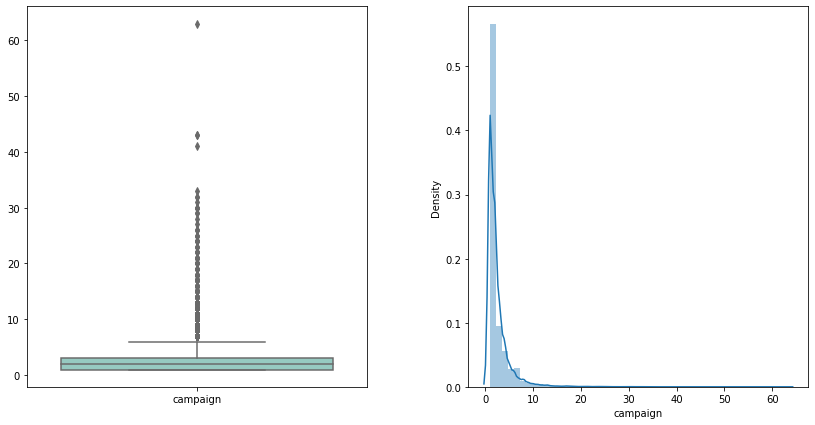

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["campaign"]], palette="Set3")
sns.distplot(data["campaign"], ax=ax[1])
plt.show()

Con respecto a esta variable, observamos que la inmensa mayoría de nuestros datos tienen un valor entre 1 y 5, mientras que los datos atípicos adquieren valores superiores a este rango. Evidentemente este es un comportamiento inusual ya que, según nuestros datos, comúnmente solo se realizan entre 1 y 5 contactos con el cliente antes de que este tome una decisión final, por ende, números de contactos iguales a 10, 20, 30 e incluso mayores a 40 son demasiado extraños de ver. Por ende, procederemos a imputar estos valores por estimaciones que se aproximen a un valor común.

#### Previous

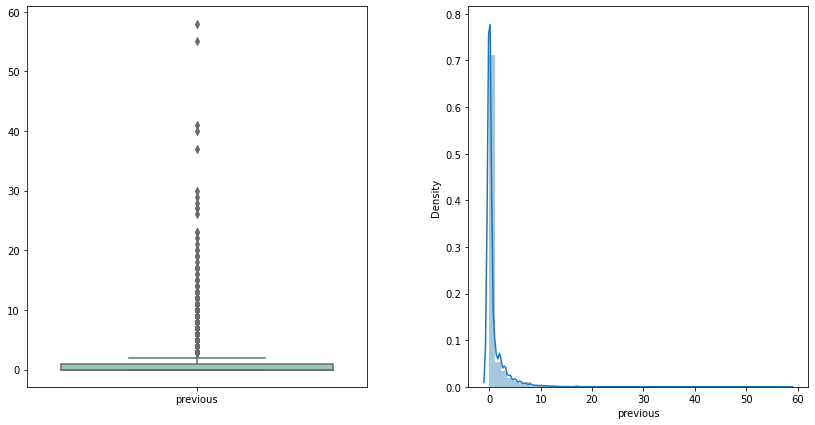

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["previous"]], palette="Set3")
sns.distplot(data["previous"], ax=ax[1])
plt.show()

Al igual que en la variable "campaign", "previous" aparte de tener una definición similar (número de contactos con el cliente en la campaña anterior), este también presenta un comportamiento similar, en donde se observa que los valores comunes están en un rango entre 0 y 3, y que los datos considerados como atípicos toman valores superiores a este rango, llegando incluso a ser excesivos. Es por ello que se tomara la misma decisión de imputarlos al igual que "campaign".

#### Balance

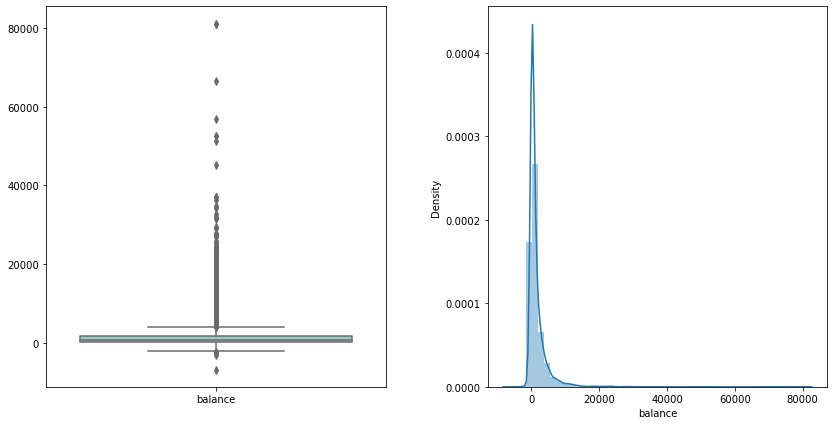

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["balance"]], palette="Set3")
sns.distplot(data["balance"], ax=ax[1])
plt.show()

Un comportamiento similar a las anteriores gráficas observamos en esta variable, donde nuevamente tenemos un sesgo por la derecha en donde los datos comunes adquieren valores entre -300 y 4000, y los que son atípicos llegan a superar fácilmente este umbral, aunque resulta más común que lo superen en forma positiva que en forma negativa, lo cual podemos deducir que, en términos de valores atípicos, es más común encontrar datos anormalmente altos que datos anormalmente bajos. Debido a que el porcentaje de datos atípicos para esta variable es del 9.4%, el cual no es un valor ni muy grande ni muy pequeño, no conviene eliminarlos, es por ello que los imputaremos por un nuevo valor aproximado que entre en un rango más común.

#### Duration

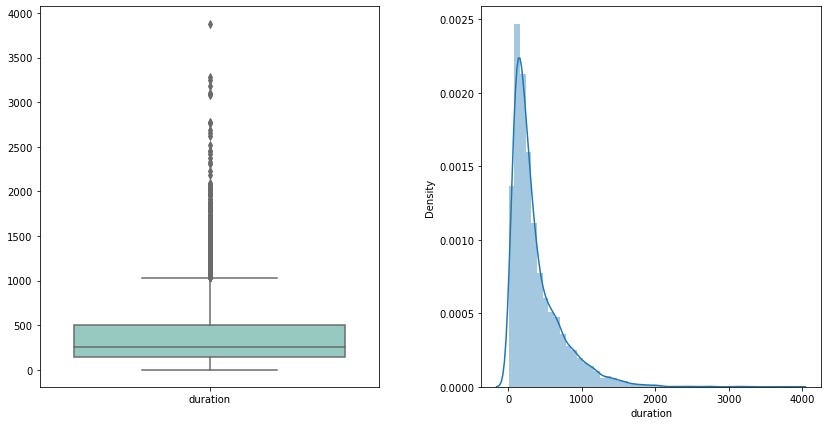

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["duration"]], palette="Set3")
sns.distplot(data["duration"], ax=ax[1])
plt.show()

Esta variable también presenta un sesgo notorio por la derecha al igual que las variables anteriores, con la diferencia que su distribución parece ser más equitativa respecto a las demás, aquí podemos apreciar que los valores comunes están en un rango entre 0 y 1000 segundos (16 minutos aprox.) y que los que son considerados atípicos superan fácilmente este rango, llegando incluso a ser superiores a los 3000 segundos (50 minutos). Observar que una llamada entre un empleado del banco y un cliente supere los 30 minutos es un comportamiento inusual y que no se acostumbra a tener, es por ello que estos datos deben ser tratados, y para este caso haremos uso de la imputación iterativa aplicando bosques aleatorios para reemplazar dichos valores por unos que se acerquen a un comportamiento común de observar.

### Imputación de outliers

Crearemos una copia del conjunto de datos original con el fin de que mas adelante podamos comparar el rendimiento de nuestro modelo predictivo en ambos conjuntos (datos con outliers y sin outliers).

In [42]:
data2 = data.copy()

El primer paso para realizar la imputación será convertir todos los valores atípicos que se hayan detectado mediante el rango intercuartílico por NaN, ya que la función que utilizaremos para la imputación trabaja con este tipo de datos.

In [43]:
outliers = (data2 < (Q1 - 1.5 * IQR)) | (data2 > (Q3 + 1.5 * IQR))
data2[outliers] = np.nan

Ahora tenemos que aplicar una codificación para nuestras variables categóricas, debido a que usaremos bosques aleatorios como medio de imputación, bastara con aplicar un label encoder.

In [44]:
# Nombres de nuestras variables categóricas
cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "deposit"]

# Diccionario para almacenar la codificación realizada en cada variable (Útil para después revertir la transformación)
dic = {}

for col in cols:
    dic[col] = LabelEncoder().fit(data2[col])
    data2[col] = dic[col].transform(data2[col])

El siguiente paso ahora es dividir nuestros datos en conjuntos de entrenamiento y prueba con el fin de evitar la fuga de datos.

In [45]:
# Guardamos los nombres de las columnas de nuestro Dataset (Útil para después concatenar estos conjuntos en uno solo)
nom_cols = data2.columns.values

X = data2.iloc[: , :-1].values
y = data2.iloc[: , -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21, stratify=y)

Finalmente, procederemos a realizar la imputación.

In [46]:
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=21), random_state=21)
X_train = imputer.fit_transform(X_train)

In [47]:
X_test = imputer.transform(X_test)

Para visualizar el resultado de nuestra imputación de forma cómoda y gráfica, será necesario concatenar todos los subconjuntos que hemos creado en uno solo como teníamos inicialmente y revertir la codificación de nuestras variables categóricas.

In [48]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

data2 = pd.concat([X, y], axis=1)

data2.columns = nom_cols  # Se les introduce los nombres de las columnas con la variable anteriormente creada

# Se invierte la codificación
for col in cols:
    data2[col] = dic[col].inverse_transform(data2[col].astype(int))

Debido a que las predicciones hechas por los bosques aleatorios se basan en el promedio del resultado de varios árboles de decisión, tendremos algunos datos imputados como decimal en variables que son enteras, como en el caso de "age", es por ello que redondearemos dichos valores decimales en cada variable que solo contenga valores enteros.

In [49]:
for col in ["age", "day", "campaign", "previous", "balance", "duration"]:
    data2[col] = data2[col].round()

Ahora si podemos graficar para observar el cambio en nuestros datos después de la imputación.

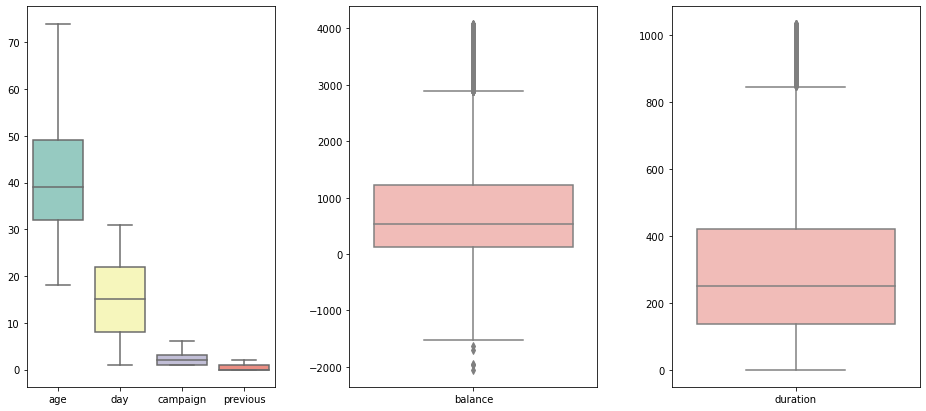

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data2[["age", "day", "campaign", "previous"]], palette="Set3")
sns.boxplot(ax=ax[1], data= data2[["balance"]], palette="Pastel1")
sns.boxplot(ax=ax[2], data= data2[["duration"]], palette="Pastel1")
plt.show()

Del grafico podemos observar que todas las variables a excepción de "balance" y "duration" están libres de outliers.

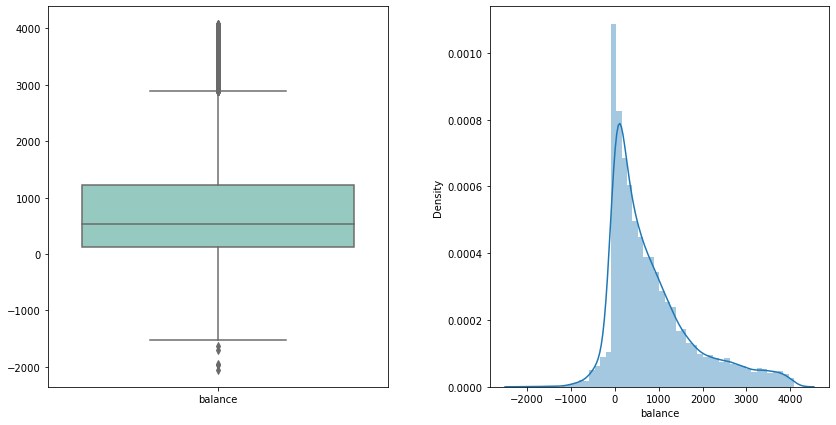

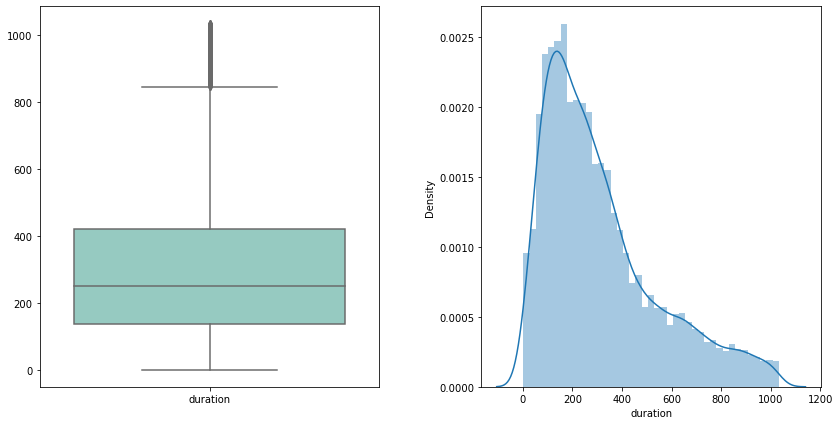

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data2[["balance"]], palette="Set3")
sns.distplot(data2["balance"], ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data2[["duration"]], palette="Set3")
sns.distplot(data2["duration"], ax=ax[1])

plt.show()

Analizando las variables que aún tienen presencia de valores atípicos, se ve que la varianza en la distribución de estos valores ya no es tan extrema como teníamos inicialmente, si no que ahora se distribuyen en un rango menor a 1000 unidades, incluso pudiéndose acercar a una distribución normal.

In [61]:
Q1 = data2.quantile(0.25)
Q3 = data2.quantile(0.75)
IQR = Q3 - Q1

In [62]:
( (data2 < (Q1 - 1.5 * IQR)) | (data2 > (Q3 + 1.5 * IQR)) ).sum() / data2.shape[0] * 100

age          0.000000
balance      5.644150
campaign     0.000000
contact      0.000000
day          0.000000
default      0.000000
deposit      0.000000
duration     4.139043
education    0.000000
housing      0.000000
job          0.000000
loan         0.000000
marital      0.000000
month        0.000000
poutcome     0.000000
previous     0.000000
dtype: float64

A la vez que también observamos que estos datos atípicos solo constituyen el 5.6% y 4.1% respectivamente del total, lo cual es una cifra moderadamente baja. Entonces podemos tomar dos decisiones, eliminarlos o conservarlos como parte de nuestros datos. En esta ocasión, elegiré conservarlos ya que pueden contener información útil para el análisis y para el modelo de clasificación, además que su presencia es relativamente baja con respecto del total y su distancia de los extremos no es tan alarmante ni exagerada.

### Identificación de valores faltantes

Observamos cuantos valores faltantes hay en nuestro conjunto de datos.

In [63]:
data2.isnull().sum().sum()

0

Debido a que no hay presencia de valores faltantes o nulos, no será necesario tomar acciones al respecto.